In [ ]:
pwd()

# Start

In [52]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [57]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.0, 0.5] # single index for z
β = [0.5, -1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 300
fx = 1 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 0 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

 12.185278 seconds (1.79 M allocations: 2.866 GiB, 14.35% gc time)
Estimation of index coefs: 
̂α => [0.4427909730238249; 0.8966248681631656]
̂γ => [0.9492770889896087, 0.42869431270431646]
Estimation of linear coefs: 
̂θ => [1.7370783404498846 -0.857842154391869]
̂β => [-0.12485959800934437; -1.4503552089194072]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [2]:
using Plots
# include("qgplsim.ji")

In [3]:
alpha

alpha (generic function with 5 methods)

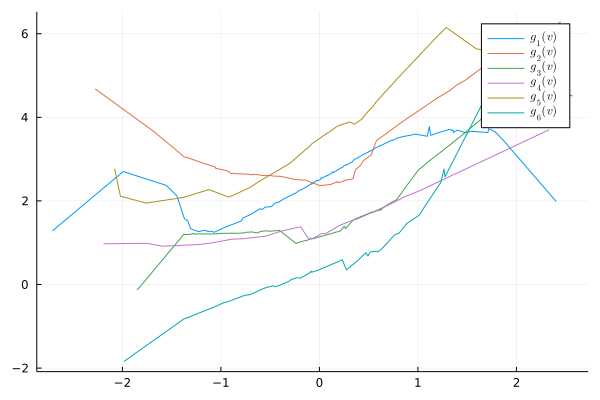

In [41]:
alphap = 1.0 * alpha1
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y - X * theta, 0.75, -0.4) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

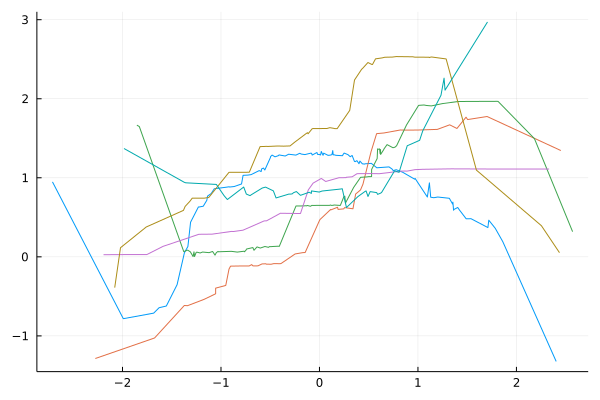

In [42]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = false )#L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [28]:
Threads.nthreads()

16

In [63]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [84]:
α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.0, 0.5] # single index for z
β = [1.0, -2.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 600
fx = 2
dist = 1 # Cauchy
rep = 100 # MC rept. times

100

In [ ]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, fx, dist, rep)


0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                       

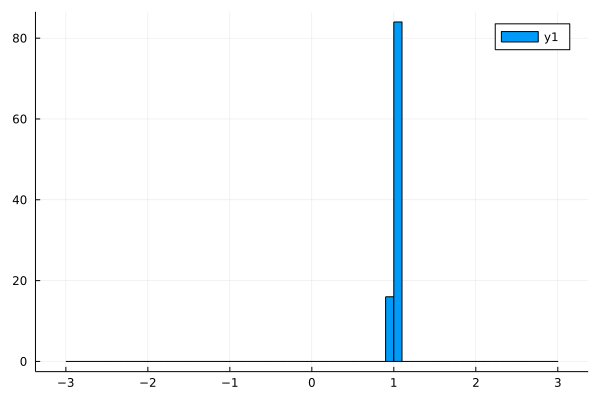

In [75]:
histogram(Alpha[:,1], bins = -3:0.1:3)

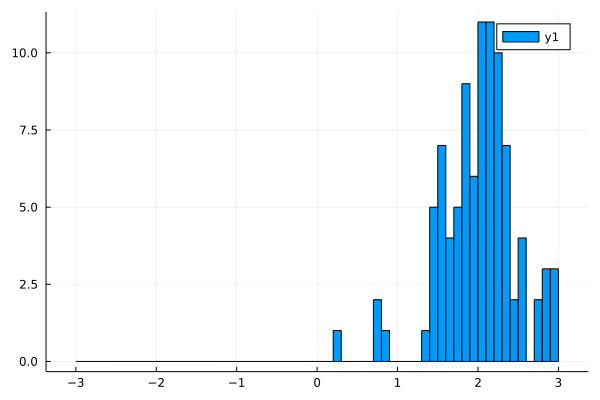

In [76]:
histogram(Alpha[:,2], bins = -3:0.1:3)

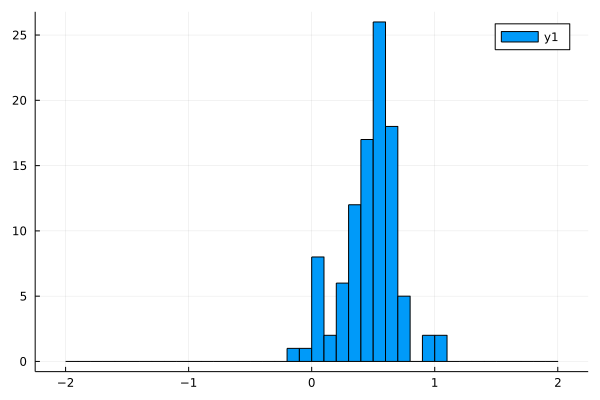

In [77]:
histogram(Gamma[:,1], bins = -2:0.1:2)

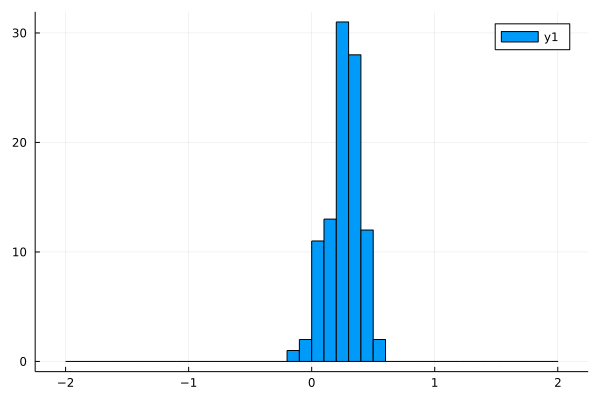

In [78]:
histogram(Gamma[:,2], bins = -2:0.1:2)

In [79]:
mg = mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.476752  0.266747

In [80]:
mg * sqrt(5)

1×2 Matrix{Float64}:
 1.06605  0.596464

In [81]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 1.0  2.12794

In [82]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 1.12505  -1.99381

In [83]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 1.96929  -0.969076

In [ ]:
(v1 * len1 + v2* len2) /(len - 1)

In [ ]:
var(abs.(Gamma), dims = 1)

In [ ]:
Ra= kmeans(transpose(Alpha), 2)
Ra.centers

In [ ]:
using DataFrames
df = DataFrame(α1 = Float64[], α2 = Float64[],
               var_α1 = Float64[], var_α2 = Float64[],    
               θ1 = Float64[], θ2 = Float64[],
               var_θ1 = Float64[], var_θ2 = Float64[], 
               β1 = Float64[], β2 = Float64[],
               var_β1 = Float64[], var_β2 = Float64[], 
               γ1 = Float64[], γ2 = Float64[],
               var_γ1 = Float64[], var_γ2 = Float64[])


In [ ]:
A = [:α1, :α2, :var_α1, :var_α2]
T = [:θ1, :θ2, :var_θ1, :var_θ2]
G = [:γ1, :γ2, :var_γ1, :var_γ2]
B = [:β1, :β2, :var_β1, :var_β2]

In [ ]:
@threads for γ in [[1.0, 0.5], [1.0, 0.001], [0.001, 1.0], [0.5, 1.0],[0.5, 0.5], [0.0001, 0.0001]]
    res, =  MonteCarlo(n, γ, θ, α, β, fx, dist, len, alpha_type)
    push!(df, res)
end